# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to own.
2. Can leverage a working neural network architecture wich has alredy learned patterns on similar data to our own, then we can adapt those patterns to our own data.

## Downloading and becoming one with the data

In [2]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-02-11 21:57:31--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.207, 172.217.203.207, 172.253.123.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   178MB/s    in 0.9s    

2024-02-11 21:57:32 (178 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 1 directories and 0 images in 10_food_classes_10_percent
There are 9 directories and 0 images in 10_food_classes_10_percent\test
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent\test\chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent\test\fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent\test\grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent\test\hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent\test\pizza
There are 0 directories and 250 images in 10_food_classes_10_percent\test\ramen
There are 0 directories and 71 images in 10_food_classes_10_percent\test\steak


## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator`class to load in our images in batches.

In [8]:
# Set up data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")
print("Test images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMAGE_SHAPE,
                                                        batch_size=BATCH_SIZE,
                                                        class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

[Callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:
- Tracking experiments with the TensorBoard callback
- Model checkpoint with the ModelCheckpoint callback
- Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback

In [9]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d - %H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

> 🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir`parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: [bo-feature-vector](https://www.kaggle.com/models/tensorflow/efficientnet/frameworks/tensorFlow2/variations/b0-feature-vector)

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [5]:
# Let's compare the following two mdoels

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [3]:
# Let's make a create_model() function to create a model from URL
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_class (int): Number of output neurons in output layer,
    should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the alredy learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

## Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [7]:
# Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

# Compile resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [8]:
# Let's fit our ResNet model to the data (1o percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240211 - 191200
Epoch 1/5
24/24 [==============================] - 122s 5s/step - loss: 1.7836 - accuracy: 0.3813 - val_loss: 1.1300 - val_accuracy: 0.6304
Epoch 2/5
24/24 [==============================] - 107s 5s/step - loss: 0.8666 - accuracy: 0.7267 - val_loss: 0.8393 - val_accuracy: 0.7280
Epoch 3/5
24/24 [==============================] - 112s 5s/step - loss: 0.6143 - accuracy: 0.8120 - val_loss: 0.7234 - val_accuracy: 0.7612
Epoch 4/5
24/24 [==============================] - 109s 5s/step - loss: 0.4610 - accuracy: 0.8893 - val_loss: 0.6973 - val_accuracy: 0.7692
Epoch 5/5
24/24 [==============================] - 105s 4s/step - loss: 0.3807 - accuracy: 0.9107 - val_loss: 0.6683 - val_accuracy: 0.7732


In [5]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separete loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # Get how many epochs

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

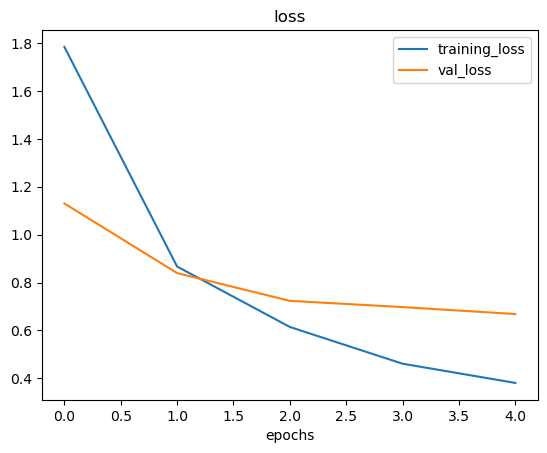

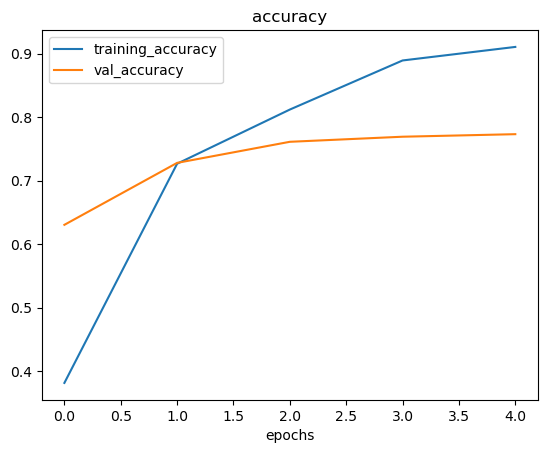

In [10]:
import matplotlib.pyplot as plt
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Extraction model

In [11]:
# Create efficientnet model
efficientnet_model = create_model(efficientnet_url,
                                  train_data_10_percent.num_classes)
# Compile efficientnet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

In [12]:
# Fit efficientnet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tensorboard_callback("tensorflow_hub",
                                                                                     "EfficientNetB0")])

Saving TensorBoard log files to: tensorflow_hub/EfficientNetB0/20240211 - 192148
Epoch 1/5
24/24 [==============================] - 64s 2s/step - loss: 1.9090 - accuracy: 0.3880 - val_loss: 1.3495 - val_accuracy: 0.7124
Epoch 2/5
24/24 [==============================] - 38s 2s/step - loss: 1.0930 - accuracy: 0.7587 - val_loss: 0.8911 - val_accuracy: 0.8048
Epoch 3/5
24/24 [==============================] - 38s 2s/step - loss: 0.7697 - accuracy: 0.8240 - val_loss: 0.7086 - val_accuracy: 0.8384
Epoch 4/5
24/24 [==============================] - 38s 2s/step - loss: 0.6158 - accuracy: 0.8707 - val_loss: 0.6215 - val_accuracy: 0.8508
Epoch 5/5
24/24 [==============================] - 39s 2s/step - loss: 0.5227 - accuracy: 0.8920 - val_loss: 0.5693 - val_accuracy: 0.8544


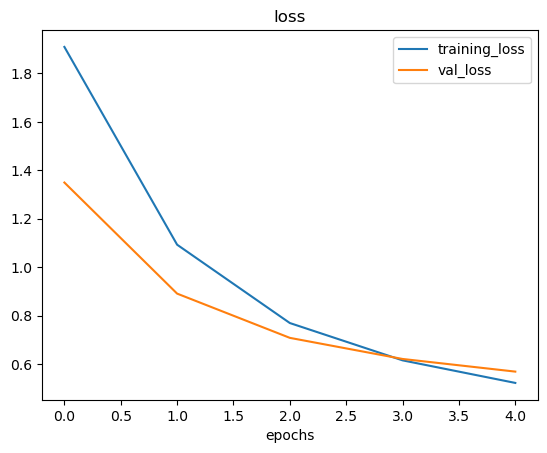

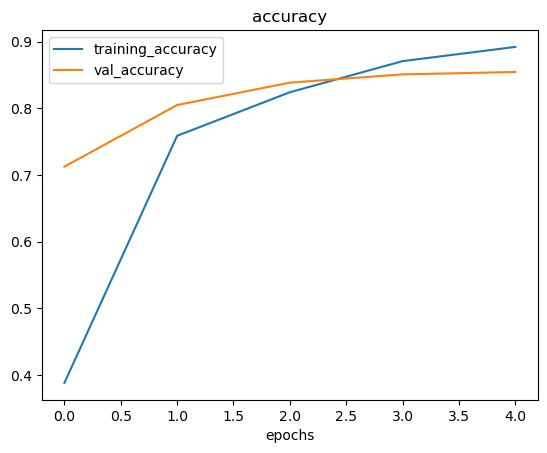

In [13]:
plot_loss_curves(efficientnet_history)

In [14]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [15]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


## Different types of transfer learning

- **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
- **Feature extraction transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your ownproblem (e.g. 1000 classes -> 10 classes of food)
- **Fine-tuning transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑 **Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.

In [17]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

^C


# 🛠️Excercises


In [10]:
mobilenet_url = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/100-224-feature-vector/versions/1"
mobilenet_model = create_model(mobilenet_url,
                               train_data_10_percent.num_classes)

In [11]:
mobilenet_model.compile(optimizer="Adam",
                        loss="categorical_crossentropy",
                        metrics=["accuracy"])

mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data_10_percent,
                                        validation_steps=len(test_data_10_percent),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="mobilenet_V2")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_V2/20240212 - 173500
Epoch 1/5
24/24 [==============================] - 50s 2s/step - loss: 1.9132 - accuracy: 0.3760 - val_loss: 1.2497 - val_accuracy: 0.6496
Epoch 2/5
24/24 [==============================] - 25s 1s/step - loss: 1.0019 - accuracy: 0.7347 - val_loss: 0.8749 - val_accuracy: 0.7472
Epoch 3/5
24/24 [==============================] - 26s 1s/step - loss: 0.7111 - accuracy: 0.8107 - val_loss: 0.7307 - val_accuracy: 0.7920
Epoch 4/5
24/24 [==============================] - 26s 1s/step - loss: 0.5667 - accuracy: 0.8520 - val_loss: 0.6720 - val_accuracy: 0.8004
Epoch 5/5
24/24 [==============================] - 26s 1s/step - loss: 0.4670 - accuracy: 0.8933 - val_loss: 0.6447 - val_accuracy: 0.7988


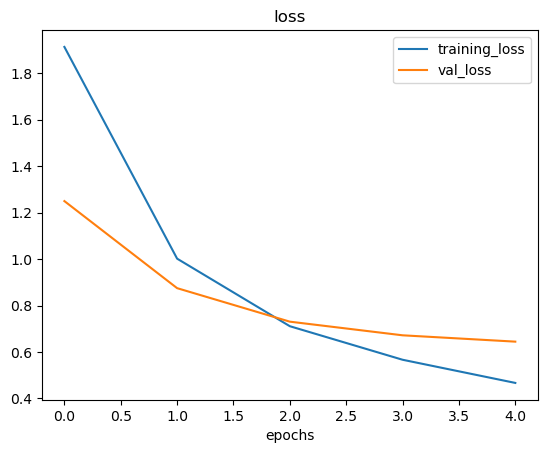

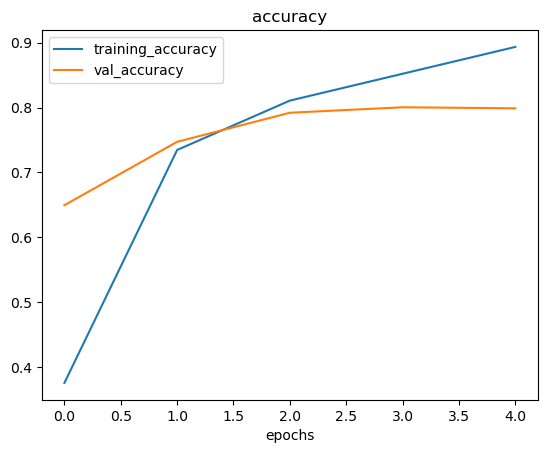

In [12]:
plot_loss_curves(mobilenet_history)

Altough it has a pretty good bechmark it looks our past models are outperformin mobilenet model